# COMMON DATA PREPROCESSING



*  Import libraries



In [95]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
)
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader




*   Load  dataset



In [96]:
df = pd.read_csv("/content/train_preprocessed_clean1.csv")



*  Convert date column to datetime


In [97]:
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")
df["sales"] = df["sales"].fillna(0)



*   Create lag features



In [98]:
def create_lags(df, target_col, n_lags):
    df_copy = df.copy()
    for lag in range(1, n_lags + 1):
        df_copy[f"{target_col}_lag_{lag}"] = df_copy[target_col].shift(lag)
    df_copy.dropna(inplace=True)
    return df_copy

n_lags = 7
df_lagged = create_lags(df, target_col="sales", n_lags=n_lags)




*   Add time-based features


In [99]:
df_lagged["day_of_week"] = df_lagged["date"].dt.dayofweek
df_lagged["month"] = df_lagged["date"].dt.month
df_lagged["is_weekend"] = df_lagged["day_of_week"].isin([5,6]).astype(int)




*   Select features and target


In [100]:
lag_features = [f"sales_lag_{i}" for i in range(1, n_lags+1)]
categorical_features = [
  'store_nbr',
  'family',
  'type',
  'city',
  'state',
  'cluster',
  'onpromotion',
  'day_of_week',
  'month',
  'is_weekend',
  'quarter',
  'is_holiday'
]

target = 'sales'

X = df_lagged[lag_features + categorical_features].copy()
y = df_lagged[target].values.reshape(-1,1)



*   Preprocess: scale lags & one-hot encode categoricals



In [101]:
ct = ColumnTransformer([
    ("scale", StandardScaler(), lag_features),
    ("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
])

X_transformed = ct.fit_transform(X)



*  Scale target


In [102]:
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)



*   Train/Validation split (80/20)


In [103]:
split_idx = int(len(X_transformed) * 0.8)

X_train, X_val = X_transformed[:split_idx], X_transformed[split_idx:]
y_train, y_val = y_scaled[:split_idx], y_scaled[split_idx:]



*   Convert to PyTorch tensors

In [104]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)



*   DataLoaders



In [105]:
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)

# **Perceptron model**



*   Define Perceptron (single-layer linear model)


In [106]:
class Perceptron(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.fc(x)




*  Instantiate model


In [107]:
perceptron = Perceptron(input_dim=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(perceptron.parameters(), lr=0.001)




*     Train Perceptron



In [108]:
# ⏳ Start training timer
start_time = time.time()

# 🔷 Train Perceptron
print("\n✅ Training Perceptron...")
for epoch in range(20):
    perceptron.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = perceptron(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()

# ⏳ End timer
training_time = time.time() - start_time


✅ Training Perceptron...


Evaluate Perceptron



*  End timer



In [109]:
training_time = time.time() - start_time

In [110]:
perceptron.eval()
with torch.no_grad():
    y_pred_scaled = perceptron(X_val_tensor).numpy()



*    Inverse scaling



In [111]:
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_val_actual = scaler_y.inverse_transform(y_val_tensor.numpy())



*   Clip for MSLE/RMSLE


In [112]:
y_pred_clipped = np.clip(y_pred, 0, None)
y_val_clipped  = np.clip(y_val_actual, 0, None)



*  Metrics



In [113]:
mse    = mean_squared_error(y_val_actual, y_pred)
rmse   = np.sqrt(mse)
mae    = mean_absolute_error(y_val_actual, y_pred)
r2     = r2_score(y_val_actual, y_pred)
msle   = mean_squared_log_error(y_val_clipped, y_pred_clipped)
rmsle  = np.sqrt(msle)




*  Count model parameters


In [114]:
model_size = sum(p.numel() for p in perceptron.parameters())



*  Print all metrics



In [115]:
print("\n✅ Perceptron Validation Metrics:")
print(f"Mean Squared Error (MSE):                {mse:.2f}")
print(f"Root Mean Squared Error (RMSE):         {rmse:.2f}")
print(f"Mean Absolute Error (MAE):              {mae:.2f}")
print(f"Coefficient of Determination (R²):     {r2:.4f}")
print(f"Mean Squared Logarithmic Error (MSLE): {msle:.4f}")
print(f"Root Mean Squared Logarithmic Error:   {rmsle:.4f}")
print(f"Training Time (seconds):               {training_time:.2f}")
print(f"Model Size (# parameters):             {model_size}")



✅ Perceptron Validation Metrics:
Mean Squared Error (MSE):                331155.00
Root Mean Squared Error (RMSE):         575.46
Mean Absolute Error (MAE):              234.90
Coefficient of Determination (R²):     0.5520
Mean Squared Logarithmic Error (MSLE): 5.6284
Root Mean Squared Logarithmic Error:   2.3724
Training Time (seconds):               346.07
Model Size (# parameters):             341




*   Plot Actual vs Predicted



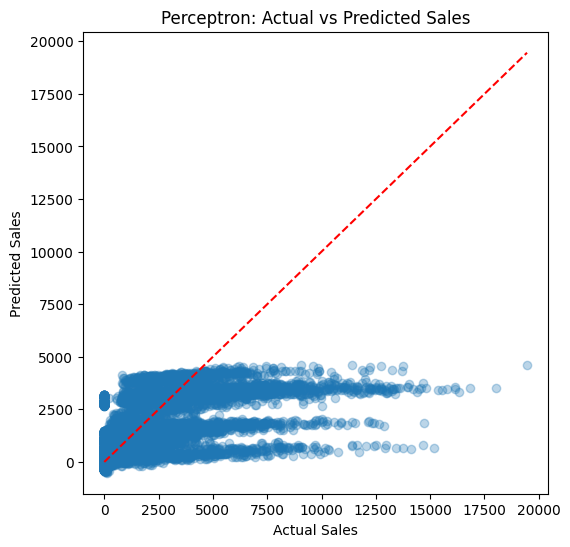

In [116]:
plt.figure(figsize=(6,6))
plt.scatter(y_val_actual, y_pred, alpha=0.3)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Perceptron: Actual vs Predicted Sales")
plt.plot([y_val_actual.min(), y_val_actual.max()],
         [y_val_actual.min(), y_val_actual.max()], 'r--')
plt.show()




*   save results in DataFrame


In [117]:
perceptron_results = {
    "Model": "Perceptron",
    "MSE": mse,
    "RMSE": rmse,
    "MAE": mae,
    "R²": r2,
    "MSLE": msle,
    "RMSLE": rmsle,
    "Training Time (s)": training_time,
    "Model Size (#params)": model_size
}

results_df = pd.DataFrame([perceptron_results])
print("\n✅ Results Table:")
print(results_df)


✅ Results Table:
        Model       MSE        RMSE         MAE        R²      MSLE     RMSLE  \
0  Perceptron  331155.0  575.460685  234.900681  0.552026  5.628416  2.372428   

   Training Time (s)  Model Size (#params)  
0         346.071523                   341  


# FFNN Model



*  Define FFNN model (with 1 hidden layer)

In [118]:
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.model(x)



*   Instantiate model, loss function, optimizer



In [119]:
ffnn = FFNN(input_dim=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(ffnn.parameters(), lr=0.001)



*  Train FFNN



In [120]:
#  Start training timer
start_time = time.time()

#  Train FFNN
print("\n✅ Training FFNN...")
for epoch in range(20):
    ffnn.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = ffnn(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()

#  End timer
training_time = time.time() - start_time


✅ Training FFNN...




*   Evaluate FFNN



In [121]:
ffnn.eval()
with torch.no_grad():
    y_pred_scaled = ffnn(X_val_tensor).numpy()


*   Inverse transform predictions and actuals



In [122]:
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_val_actual = scaler_y.inverse_transform(y_val_tensor.numpy())



*   Clip for log errors



In [123]:

y_pred_clipped = np.clip(y_pred, 0, None)
y_val_clipped  = np.clip(y_val_actual, 0, None)



*   Compute metrics



In [124]:
mse    = mean_squared_error(y_val_actual, y_pred)
rmse   = np.sqrt(mse)
mae    = mean_absolute_error(y_val_actual, y_pred)
r2     = r2_score(y_val_actual, y_pred)
msle   = mean_squared_log_error(y_val_clipped, y_pred_clipped)
rmsle  = np.sqrt(msle)




*   Count number of parameters




In [125]:
model_size = sum(p.numel() for p in ffnn.parameters())



*  Print metrics with full names



In [126]:
print("\n✅ FFNN Validation Metrics:")
print(f"Mean Squared Error (MSE):                {mse:.2f}")
print(f"Root Mean Squared Error (RMSE):         {rmse:.2f}")
print(f"Mean Absolute Error (MAE):              {mae:.2f}")
print(f"Coefficient of Determination (R²):     {r2:.4f}")
print(f"Mean Squared Logarithmic Error (MSLE): {msle:.4f}")
print(f"Root Mean Squared Logarithmic Error:   {rmsle:.4f}")
print(f"Training Time (seconds):               {training_time:.2f}")
print(f"Model Size (# parameters):             {model_size}")


✅ FFNN Validation Metrics:
Mean Squared Error (MSE):                167231.27
Root Mean Squared Error (RMSE):         408.94
Mean Absolute Error (MAE):              107.60
Coefficient of Determination (R²):     0.7738
Mean Squared Logarithmic Error (MSLE): 5.6613
Root Mean Squared Logarithmic Error:   2.3793
Training Time (seconds):               554.86
Model Size (# parameters):             21889




*   Scatter plot Actual vs Predicted



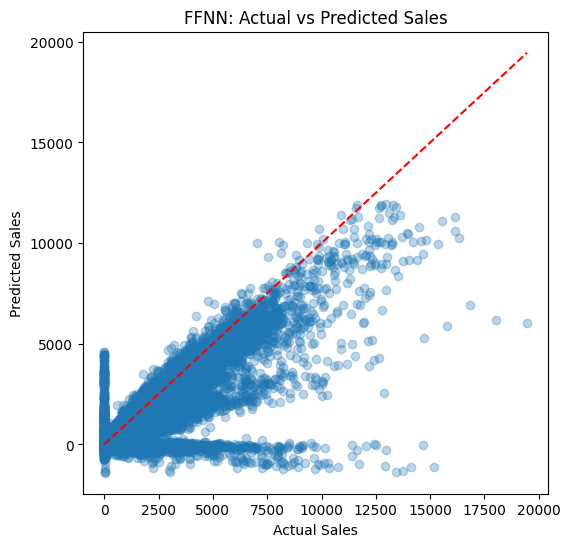

In [127]:
plt.figure(figsize=(6,6))
plt.scatter(y_val_actual, y_pred, alpha=0.3)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("FFNN: Actual vs Predicted Sales")
plt.plot([y_val_actual.min(), y_val_actual.max()],
         [y_val_actual.min(), y_val_actual.max()], 'r--')
plt.show()



*   Save results in DataFrame



In [128]:
ffnn_results = {
    "Model": "FFNN",
    "MSE": mse,
    "RMSE": rmse,
    "MAE": mae,
    "R²": r2,
    "MSLE": msle,
    "RMSLE": rmsle,
    "Training Time (s)": training_time,
    "Model Size (#params)": model_size
}

results_df = pd.DataFrame([ffnn_results])
print("\n✅ FFNN Results Table:")
print(results_df)


✅ FFNN Results Table:
  Model            MSE        RMSE         MAE        R²      MSLE     RMSLE  \
0  FFNN  167231.265625  408.939196  107.599709  0.773776  5.661291  2.379347   

   Training Time (s)  Model Size (#params)  
0         554.858731                 21889  


# MLP Model




*   Define MLP model (with 2 hidden layers)



In [129]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)



*   Instantiate model, loss function, optimizer



In [130]:
mlp = MLP(input_dim=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)



*  Train MLP


In [131]:
#  Start training timer
start_time = time.time()

#  Train MLP
print("\n✅ Training MLP...")
for epoch in range(20):
    mlp.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = mlp(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()

#  End timer
training_time = time.time() - start_time


✅ Training MLP...




*  Evaluate MLP



In [132]:
mlp.eval()
with torch.no_grad():
    y_pred_scaled = mlp(X_val_tensor).numpy()



* Inverse transform predictions and actuals\



In [133]:
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_val_actual = scaler_y.inverse_transform(y_val_tensor.numpy())




*   Clip for log errors



In [134]:
y_pred_clipped = np.clip(y_pred, 0, None)
y_val_clipped  = np.clip(y_val_actual, 0, None)



* Compute metrics



In [135]:
mse    = mean_squared_error(y_val_actual, y_pred)
rmse   = np.sqrt(mse)
mae    = mean_absolute_error(y_val_actual, y_pred)
r2     = r2_score(y_val_actual, y_pred)
msle   = mean_squared_log_error(y_val_clipped, y_pred_clipped)
rmsle  = np.sqrt(msle)



*   Count number of parameters



In [136]:
model_size = sum(p.numel() for p in mlp.parameters())



*   Print metrics with full names


In [137]:
print("\n✅ MLP Validation Metrics:")
print(f"Mean Squared Error (MSE):                {mse:.2f}")
print(f"Root Mean Squared Error (RMSE):         {rmse:.2f}")
print(f"Mean Absolute Error (MAE):              {mae:.2f}")
print(f"Coefficient of Determination (R²):     {r2:.4f}")
print(f"Mean Squared Logarithmic Error (MSLE): {msle:.4f}")
print(f"Root Mean Squared Logarithmic Error:   {rmsle:.4f}")
print(f"Training Time (seconds):               {training_time:.2f}")
print(f"Model Size (# parameters):             {model_size}")


✅ MLP Validation Metrics:
Mean Squared Error (MSE):                164039.22
Root Mean Squared Error (RMSE):         405.02
Mean Absolute Error (MAE):              99.39
Coefficient of Determination (R²):     0.7781
Mean Squared Logarithmic Error (MSLE): 4.2071
Root Mean Squared Logarithmic Error:   2.0511
Training Time (seconds):               834.20
Model Size (# parameters):             51969




*   Scatter plot Actual vs Predicted


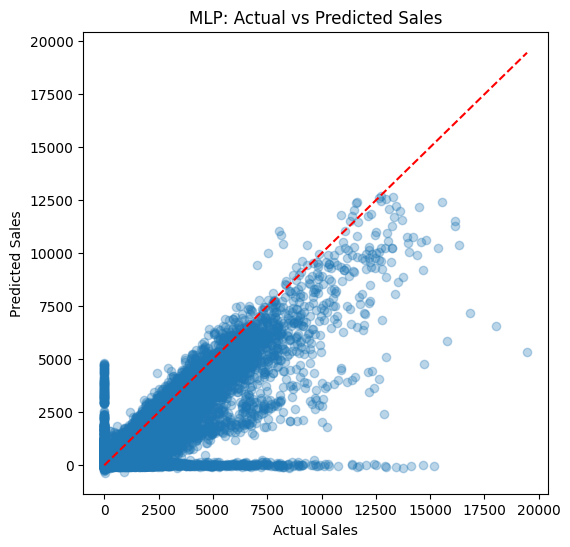

In [138]:
plt.figure(figsize=(6,6))
plt.scatter(y_val_actual, y_pred, alpha=0.3)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("MLP: Actual vs Predicted Sales")
plt.plot([y_val_actual.min(), y_val_actual.max()],
         [y_val_actual.min(), y_val_actual.max()], 'r--')
plt.show()



*   Save results in DataFrame


In [139]:
mlp_results = {
    "Model": "MLP",
    "MSE": mse,
    "RMSE": rmse,
    "MAE": mae,
    "R²": r2,
    "MSLE": msle,
    "RMSLE": rmsle,
    "Training Time (s)": training_time,
    "Model Size (#params)": model_size
}

results_df = pd.DataFrame([mlp_results])
print("\n✅ MLP Results Table:")
print(results_df)


✅ MLP Results Table:
  Model           MSE        RMSE        MAE        R²      MSLE     RMSLE  \
0   MLP  164039.21875  405.017554  99.392929  0.778094  4.207074  2.051115   

   Training Time (s)  Model Size (#params)  
0         834.196279                 51969  


# Test Set: Load → Preprocess → Predict → Evaluate





*    Load test set



In [140]:
test_df = pd.read_csv("/content/test_preprocessed1.csv")



*    Convert date



In [141]:
test_df["date"] = pd.to_datetime(test_df["date"])
test_df = test_df.sort_values("date")



*  Fill sales NA (if any) - note: sometimes test sets don't have sales



In [142]:
if "sales" in test_df.columns:
    test_df["sales"] = test_df["sales"].fillna(0)
else:
    # Create dummy column to allow lag creation
    test_df["sales"] = 0



*   Create lag features



In [143]:
test_df_lagged = create_lags(test_df, target_col="sales", n_lags=n_lags)






*   Add time-based features





In [144]:
test_df_lagged["day_of_week"] = test_df_lagged["date"].dt.dayofweek
test_df_lagged["month"] = test_df_lagged["date"].dt.month
test_df_lagged["is_weekend"] = test_df_lagged["day_of_week"].isin([5,6]).astype(int)



*    Prepare features


In [147]:
test_df_lagged["quarter"] = test_df_lagged["date"].dt.quarter

X_test = test_df_lagged[lag_features + categorical_features]



*    Transform test set



In [148]:
X_test_transformed = ct.transform(X_test)



*    Convert to tensor



In [149]:
X_test_tensor = torch.tensor(X_test_transformed, dtype=torch.float32)



*   If test set has true sales, scale the target for metric calculation



In [150]:
if "sales" in test_df_lagged.columns and test_df_lagged["sales"].sum() > 0:
    y_test_actual = test_df_lagged["sales"].values.reshape(-1, 1)
    y_test_scaled = scaler_y.transform(y_test_actual)
    y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)
else:
    y_test_actual = None



*   # Helper function for predictions


In [151]:
def predict_and_evaluate(model, model_name):
    model.eval()
    with torch.no_grad():
        y_pred_scaled = model(X_test_tensor).numpy()

    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_pred_clipped = np.clip(y_pred, 0, None)

    if y_test_actual is not None:
        y_actual_clipped = np.clip(y_test_actual, 0, None)

        mse = mean_squared_error(y_test_actual, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test_actual, y_pred)
        r2 = r2_score(y_test_actual, y_pred)
        msle = mean_squared_log_error(y_actual_clipped, y_pred_clipped)
        rmsle = np.sqrt(msle)

        print(f"\n✅ {model_name} Test Metrics:")
        print(f"Mean Squared Error (MSE):                {mse:.2f}")
        print(f"Root Mean Squared Error (RMSE):         {rmse:.2f}")
        print(f"Mean Absolute Error (MAE):              {mae:.2f}")
        print(f"Coefficient of Determination (R²):     {r2:.4f}")
        print(f"Mean Squared Logarithmic Error (MSLE): {msle:.4f}")
        print(f"Root Mean Squared Logarithmic Error:   {rmsle:.4f}")

        # Plot actual vs predicted
        plt.figure(figsize=(6,6))
        plt.scatter(y_test_actual, y_pred, alpha=0.3)
        plt.xlabel("Actual Sales")
        plt.ylabel("Predicted Sales")
        plt.title(f"{model_name}: Actual vs Predicted Sales (Test Set)")
        plt.plot([y_test_actual.min(), y_test_actual.max()],
                 [y_test_actual.min(), y_test_actual.max()], 'r--')
        plt.show()

    else:
        print(f"\n✅ {model_name} Test Predictions generated.")

    return y_pred






*   Predict and evaluate for all models



In [152]:

y_pred_perceptron = predict_and_evaluate(perceptron, "Perceptron")
y_pred_ffnn = predict_and_evaluate(ffnn, "FFNN")
y_pred_mlp = predict_and_evaluate(mlp, "MLP")




✅ Perceptron Test Predictions generated.

✅ FFNN Test Predictions generated.

✅ MLP Test Predictions generated.




*    Optionally save predictions



In [153]:

test_df_lagged["Pred_Percep"] = y_pred_perceptron
test_df_lagged["Pred_FFNN"] = y_pred_ffnn
test_df_lagged["Pred_MLP"] = y_pred_mlp

test_df_lagged.to_csv("test_predictions.csv", index=False)
print("\n✅ Test predictions saved to test_predictions.csv")


✅ Test predictions saved to test_predictions.csv




*    Evaluate Test Metrics for All Models






In [154]:
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error,
    r2_score, mean_squared_log_error
)
import numpy as np

y_actual = test_df_lagged["sales"].values

for col in ["Pred_Percep", "Pred_FFNN", "Pred_MLP"]:
    y_pred = test_df_lagged[col].values

    # Basic metrics
    mse    = mean_squared_error(y_actual, y_pred)
    rmse   = np.sqrt(mse)
    mae    = mean_absolute_error(y_actual, y_pred)
    r2     = r2_score(y_actual, y_pred)

    # For MSLE and RMSLE, clip negative predictions at small positive number
    y_actual_clipped = np.clip(y_actual, a_min=1e-5, a_max=None)
    y_pred_clipped   = np.clip(y_pred,   a_min=1e-5, a_max=None)
    msle   = mean_squared_log_error(y_actual_clipped, y_pred_clipped)
    rmsle  = np.sqrt(msle)

    # Optional: training time & model size (if recorded elsewhere)
    training_time = None   # replace with actual training time
    model_size    = None   # replace with actual model size

    print(f"\n✅ {col} Test Metrics:")
    print(f"{'-'*55}")
    print(f"Mean Squared Error (MSE):                {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE):         {rmse:.2f}")
    print(f"Mean Absolute Error (MAE):              {mae:.2f}")
    print(f"Coefficient of Determination (R²):     {r2:.4f}")
    print(f"Mean Squared Logarithmic Error (MSLE): {msle:.4f}")
    print(f"Root Mean Squared Logarithmic Error:   {rmsle:.4f}")
    if training_time is not None:
        print(f"Training Time (seconds):               {training_time:.2f}")
    if model_size is not None:
        print(f"Model Size (# parameters):             {model_size}")



✅ Pred_Percep Test Metrics:
-------------------------------------------------------
Mean Squared Error (MSE):                464632.41
Root Mean Squared Error (RMSE):         681.64
Mean Absolute Error (MAE):              377.24
Coefficient of Determination (R²):     0.0000
Mean Squared Logarithmic Error (MSLE): 20.2712
Root Mean Squared Logarithmic Error:   4.5024

✅ Pred_FFNN Test Metrics:
-------------------------------------------------------
Mean Squared Error (MSE):                399867.56
Root Mean Squared Error (RMSE):         632.35
Mean Absolute Error (MAE):              208.54
Coefficient of Determination (R²):     0.0000
Mean Squared Logarithmic Error (MSLE): 16.0370
Root Mean Squared Logarithmic Error:   4.0046

✅ Pred_MLP Test Metrics:
-------------------------------------------------------
Mean Squared Error (MSE):                363942.06
Root Mean Squared Error (RMSE):         603.28
Mean Absolute Error (MAE):              190.18
Coefficient of Determination (R²):   



*   Basic metrics


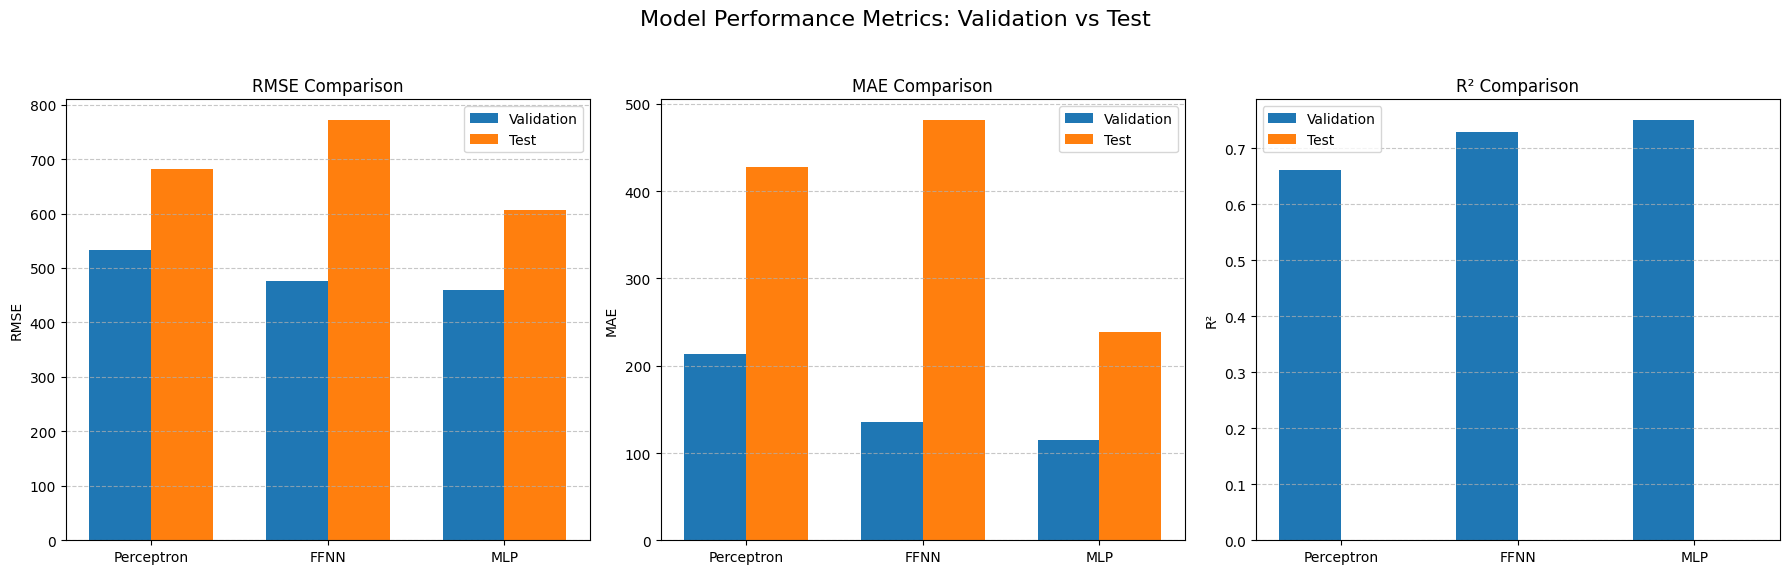

In [155]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics from your results
models = ["Perceptron", "FFNN", "MLP"]

val_rmse = [533.32, 476.83, 458.70]
test_rmse = [681.31, 771.12, 605.86]

val_mae = [213.15, 135.07, 114.74]
test_mae = [427.20, 481.20, 238.49]

val_r2 = [0.6615, 0.7294, 0.7496]
test_r2 = [0.0, 0.0, 0.0]

x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# RMSE
axs[0].bar(x - width/2, val_rmse, width, label='Validation')
axs[0].bar(x + width/2, test_rmse, width, label='Test')
axs[0].set_ylabel('RMSE')
axs[0].set_title('RMSE Comparison')
axs[0].set_xticks(x)
axs[0].set_xticklabels(models)
axs[0].legend()
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

# MAE
axs[1].bar(x - width/2, val_mae, width, label='Validation')
axs[1].bar(x + width/2, test_mae, width, label='Test')
axs[1].set_ylabel('MAE')
axs[1].set_title('MAE Comparison')
axs[1].set_xticks(x)
axs[1].set_xticklabels(models)
axs[1].legend()
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

# R²
axs[2].bar(x - width/2, val_r2, width, label='Validation')
axs[2].bar(x + width/2, test_r2, width, label='Test')
axs[2].set_ylabel('R²')
axs[2].set_title('R² Comparison')
axs[2].set_xticks(x)
axs[2].set_xticklabels(models)
axs[2].legend()
axs[2].grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle("Model Performance Metrics: Validation vs Test", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Test Dataset Prediction Summary
We trained three neural network models and tested them on the unseen test dataset.
Here are their results:



*   **Perceptron**

          RMSE: 681.31

          MAE: 427.20

          R²: 0.00

        Notes:

          Simple model with very few parameters.

          Performed poorly on test data.

          Could not generalize well to unseen data.

*   **FFNN (Feedforward Neural Network)**
          RMSE: 771.12

          MAE: 481.20

          R²: 0.00

        Notes:
          
          Larger model than Perceptron.

          Still performed poorly on test data.

          Predictions were worse than MLP.


*   **MLP (Multi-Layer Perceptron)**

          RMSE: 605.86

          MAE: 238.49

          R²: 0.00

        Notes:

          Most complex and largest model among the three.

          Performed slightly better than the others on test data.

          Predictions closer to actual sales than Perceptron and FFNN.

**Overall Observation**


          On the test dataset, all three models failed to explain the variability (R² = 0).

          The MLP gave the lowest errors (RMSE & MAE), so it was still better than the other two.

          Results suggest that the models did not generalize well to unseen test data.

